In [172]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installing packages, downloading necessary files and features

In [173]:
!pip install PyPro
!pip install propy3
!pip install modlamp
!pip install brewer2mpl

In [174]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
import random
import seaborn as sns
import sklearn
from propy import PyPro
from modlamp.database import query_database
from modlamp.descriptors import PeptideDescriptor, GlobalDescriptor
from modlamp.sequences import Helices
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

In [175]:
#Reading files and filtering sequences
def read_and_filter(path, filenames):
    peptides = {}
    peptides_length = []
    for name in filenames:
        filename = path + filenames[name]
        seq = ''
        with open(filename, 'r') as file:
            for line in file:
                if line[0] != '>':
                    flag = True
                    seq = replace_all(line.strip(), label)
                if seq not in peptides and len(seq) > 4 and not set(seq) - set(amino_acids):
                    peptides[seq] = [name, len(seq)]
                    peptides_length.append(len(seq))
    return peptides, peptides_length

#Tag removal
def replace_all(text, to_replase):
    for key in to_replase:
        text = text.replace(key, to_replase[key])
    return text

#Source of sequences
def web_resource(filenames, peptides):
    resource = filenames.keys()
    result = dict.fromkeys(resource, 0)
    for key in peptides:
        result[peptides[key][0]] += 1
    print(result)

#Record to file
def writing_to_file(filename, data):
    with open(filename, 'w') as file:
        for key in data:
            file.write(key + '\n')

#Recording descriptor dictionary
def create_a_dictionary(feature, parameter):
    if len(feature) == 0:
        for key in parameter:
            feature[key] = [parameter[key]]
    else:
        if parameter != 0:
            for key in parameter:
                feature[key].append(parameter[key])
        else:
            for key in feature:
                feature[key].append(0)
    return feature

#Removal of highly correlated descriptors
def corr_descriptors(data, corr_val):
    corr_matrix = data.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = item.values
            if val >= corr_val:
                #print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(i)
    drops = sorted(set(drop_cols))[::-1]
    new_data = data.copy()
    for i in drops:
        del new_data[data.columns[i]]
    return new_data

#Heat map construction
def create_a_corr_table(df_feature, flag):
    corr_table = round(df_feature.corr(), 2)
    plt.figure(figsize=(120,60), dpi= 100)
    sns.heatmap(abs(corr_table), xticklabels=corr_table.columns, yticklabels=corr_table.columns, alpha = 0.75,
                cmap=sns.diverging_palette(0, 125, as_cmap=True), annot=flag, center = 0, square=True)
    plt.xticks(rotation=90)
    plt.show()

#Image formatting
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

<ipython-input-175-acae8ecb4b2e>:92: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [176]:
CPP_sample_path = '/content/drive/MyDrive/TriplEP-CPP/Training sample/'

CPP_pos_names = {'CPPsite2.0' : 'natural_pep_CPP20.txt'}
CPP_neg_names = {'Swiss-prot' : 'natural_pep_SwissP.txt'}

amino_acids = ['A','R','N','D','C','H','G','Q','E','I','L','K','M','P','S','Y','T','W','F','V']
label = {'Biotin(O)': '', 'CREKA': '', 'Ac': '', 'mPEG-PLA': '', 'mPEGPLA': '',
         'PEG-PLA': '', 'PEGPLA': '', 'Ahx': '', 'ahx': '', 'ISF': '', 'mPEGPLA': '',
         'R8': 'RRRRRRRR', 'S5': 'SSSSS', '-':''}

# Sequence reading and pre-processing

Combine files from different databases (if necessary), remove duplicates and peptides with atypical amino acids

## Cell-penetrating peptides

In [ ]:
CPP_pos, CPP_pos_length = read_and_filter(CPP_sample_path, CPP_pos_names)
web_resource(CPP_pos_names, CPP_pos)
print('Minimum length', min(CPP_pos_length), '\nMaximum length', max(CPP_pos_length))

{'CPPsite2.0': 1168}
Minimum length 5 
Maximum length 61


In [ ]:
file_name = CPP_sample_path + 'CPPs_positive.txt'
writing_to_file(file_name, CPP_pos)

## Non cell-penetrating peptides

In [ ]:
CPP_neg, CPP_neg_length = read_and_filter(CPP_sample_path, CPP_neg_names)

Non-penetrating peptides were run through CD-HIT with sequence identity cut-off = 0.45 and length of sequence to skip = 5 (the others are default) to remove homologous sequences.

This resulted in 1351 sequences in the file CD_HIT_nonCPP.fasta

In [ ]:
CD_HIT_nonCPP = []
CD_HIT_name = CPP_sample_path + 'CD_HIT_nonCPP.fasta'
with open(CD_HIT_name, 'r') as file:
    for line in file:
        l = line.strip()
        if l != '' and l[0] != '>':
            CD_HIT_nonCPP.append(l)

#Purification
double_dict = CPP_neg.copy()
for key in double_dict.keys():
    if key not in CD_HIT_nonCPP or key in CPP_pos:
        del CPP_neg[key]

#Peptide lengths
CPP_neg_length = list()
for key in CPP_neg:
    CPP_neg_length.append(CPP_neg[key][1])

file_name = CPP_sample_path + 'CPPs_negative.txt'
writing_to_file(file_name, CPP_neg)

In [ ]:
web_resource(CPP_neg_names, CPP_neg)
print('Minimum length', min(CPP_neg_length), '\nMaximum length', max(CPP_neg_length))

{'Swiss-prot': 1212}
Minimum length 5 
Maximum length 58


## Length distribution

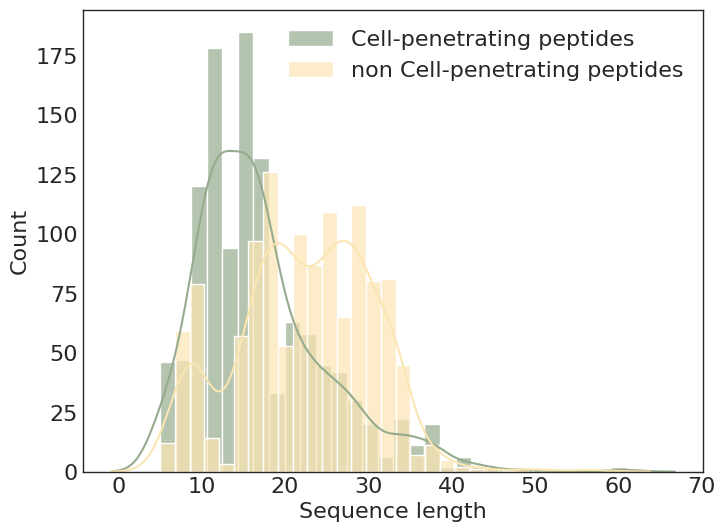

In [ ]:
plt.figure(figsize=(8,6), dpi= 100)
sns.histplot(CPP_pos_length, color='#96ab8d', label="Cell-penetrating peptides",
             alpha=.7, kde_kws=dict(cut=3), bins = 30, kde=True)
sns.histplot(CPP_neg_length, color='#fbe5b3', label="non Cell-penetrating peptides",
                     alpha=.7, kde_kws=dict(cut=3), bins = 30, kde=True)

plt.ylabel("Count")
plt.xlabel("Sequence length")
plt.legend()
plt.show()

# Training sample generation

In [ ]:
Sample = {'CPP': [True]*len(CPP_pos) + [False]*len(CPP_neg),
          'Sequence': list(CPP_pos.keys()) + list(CPP_neg.keys())}
df_SAMPLE = pd.DataFrame(Sample)
#df_SAMPLE.to_csv(CPP_sample_path + 'df_SAMPLE_no_desc.csv', index = False)
#df_SAMPLE = pd.read_csv(CPP_sample_path + 'df_SAMPLE_no_desc.csv')

## Primary descriptors

### APAAC

Amphiphilic pseudo amino acid composition descriptors(depend on the choice of lamda, the default is 50)

In [ ]:
APAAC = {}
for i in range(len(df_SAMPLE)):
    DesObject = PyPro.GetProDes(df_SAMPLE['Sequence'][i])
    try:
        apaac = DesObject.GetAPAAC()
    except ZeroDivisionError:
        apaac = 0
    APAAC = create_a_dictionary(APAAC, apaac)

In [ ]:
APAAC_with_A = {}

for key in APAAC.keys():
    old_key = key
    if key[0] != 'A':
        key = 'A' + key
    APAAC_with_A[key] = APAAC[old_key]
APAAC = pd.DataFrame(APAAC_with_A)

### PAAC
Pseudo amino acid composition descriptors (depend on the choice of lamda, the default is 50)

In [ ]:
PAAC = {}
for i in range(len(df_SAMPLE)):
    DesObject = PyPro.GetProDes(df_SAMPLE['Sequence'][i])
    try:
        paac = DesObject.GetPAAC()
    except ZeroDivisionError:
        paac = 0
    PAAC = create_a_dictionary(PAAC, paac)
PAAC = pd.DataFrame(PAAC)

### QSO
Quasi-sequence order descriptors (depend on the choice of maxlag, the default is 100)

In [ ]:
QSO = {}
for i in range(len(df_SAMPLE)):
    DesObject = PyPro.GetProDes(df_SAMPLE['Sequence'][i])
    try:
        qso = DesObject.GetQSO()
    except ZeroDivisionError:
        qso = 0
    QSO = create_a_dictionary(QSO, qso)
QSO = pd.DataFrame(QSO)

### SOCN
Sequence order coupling numbers (depend on the choice of maxlag, the default is 60)

In [ ]:
SOCN = {}
for i in range(len(df_SAMPLE)):
    DesObject = PyPro.GetProDes(df_SAMPLE['Sequence'][i])
    try:
        socn = DesObject.GetSOCN()
    except ZeroDivisionError:
        socn = 0
    SOCN = create_a_dictionary(SOCN, socn)
SOCN = pd.DataFrame(SOCN)

### CTD
Composition, Transition, Distribution descriptors (CTD) (21+21+105=147)

In [ ]:
CTD = {}
for i in range(len(df_SAMPLE)):
    DesObject = PyPro.GetProDes(df_SAMPLE['Sequence'][i])
    try:
        ctd = DesObject.GetCTD()
    except ZeroDivisionError:
        ctd = 0
    CTD = create_a_dictionary(CTD, ctd)
CTD = pd.DataFrame(CTD)

### Gearyauto
Geary autocorrelation descriptors(depend on the given properties, the default is 240)

In [ ]:
GEAR = {}
for i in range(len(df_SAMPLE)):
    DesObject = PyPro.GetProDes(df_SAMPLE['Sequence'][i])
    try:
        gear = DesObject.GetGearyAuto()
    except ZeroDivisionError:
        gear = 0
    GEAR = create_a_dictionary(GEAR, gear)
GEAR = pd.DataFrame(GEAR)

### Moranauto
Moran autocorrelation descriptors(depend on the given properties, the default is 240)

In [ ]:
MORAN = {}
for i in range(len(df_SAMPLE)):
    DesObject = PyPro.GetProDes(df_SAMPLE['Sequence'][i])
    try:
        moran = DesObject.GetMoranAuto()
    except ZeroDivisionError:
        moran = 0
    MORAN = create_a_dictionary(MORAN, moran)
MORAN = pd.DataFrame(MORAN)

### MBauto
Normalized Moreau-Broto autocorrelation descriptors (depend on the given properties, the default is 240)

In [ ]:
MB = {}
for i in range(len(df_SAMPLE)):
    DesObject = PyPro.GetProDes(df_SAMPLE['Sequence'][i])
    try:
        mb = DesObject.GetMoreauBrotoAuto()
    except ZeroDivisionError:
        mb = 0
    MB = create_a_dictionary(MB, mb)
MB = pd.DataFrame(MB)

### modlAMP

In [ ]:
AMP = GlobalDescriptor(list(df_SAMPLE['Sequence']))

AMP.charge_density(ph=6, amide=True)
ch_density = pd.DataFrame({"ChargeDensity": AMP.descriptor.flatten().tolist()})

AMP.isoelectric_point()
i_point = pd.DataFrame({"pI": AMP.descriptor.flatten().tolist()})

AMP.instability_index()
i_index = pd.DataFrame({"InstabilityInd": AMP.descriptor.flatten().tolist()})

AMP.aromaticity()
aromatic = pd.DataFrame({"Aromaticity": AMP.descriptor.flatten().tolist()})

AMP.aliphatic_index()
a_index = pd.DataFrame({"AliphaticInd": AMP.descriptor.flatten().tolist()})

AMP.boman_index()
b_index = pd.DataFrame({"BomanInd": AMP.descriptor.flatten().tolist()})

AMP.hydrophobic_ratio()
h_ratio = pd.DataFrame({"HydrophRatio": AMP.descriptor.flatten().tolist()})

modlamp_descriptors = [ch_density, i_point, i_index, aromatic, a_index, b_index, h_ratio]
modl_AMP = modlamp_descriptors[0]
for df in modlamp_descriptors[1:]:
    modl_AMP = pd.concat([modl_AMP, df], axis = 1)

## Correlation tables construction

In [ ]:
all_descriptors = [APAAC, PAAC, QSO, SOCN, CTD, GEAR, MORAN, MB, modl_AMP]
all_descriptors_names = ['APAAC', 'PAAC', 'QSO', 'SOCN', 'CTD', 'GEAR', 'MORAN', 'MB', 'modl_AMP']

In [ ]:
flag_for_annot = list()
for n in all_descriptors:
    flag_for_annot.append(len(n.columns) < 50)
font_scale = [2.5,3,0,0,0,0,0,0,9]
for name, desc, flag, font in zip(all_descriptors_names, all_descriptors, flag_for_annot, font_scale):
    if flag:
        sns.set(font_scale=font)
        print('Heat map for a group of descriptors', name)
        create_a_corr_table(desc, flag)

Output hidden; open in https://colab.research.google.com to view.

## Removal of highly correlated descriptors

In [ ]:
all_descriptors = [APAAC, PAAC, QSO, SOCN, CTD, GEAR, MORAN, MB, modl_AMP]
df_DESC_not_corr = all_descriptors[0]
for df in all_descriptors[1:]:
    df_DESC_not_corr = pd.concat([df_DESC_not_corr, df], axis = 1)
df_DESC_corr = corr_descriptors(df_DESC_not_corr, 0.9)
df_SAMPLE = pd.concat([df_SAMPLE, df_DESC_corr], axis = 1)
#df_SAMPLE.to_csv(CPP_sample_path + 'df_SAMPLE.csv', index = False)
#df_DESC_corr.to_csv(CPP_sample_path + 'df_DESC_corr.csv', index = False)

## Dimensionality reduction

In [ ]:
#Read file with descriptors (if necessary) and select vector y
df_SAMPLE = pd.read_csv(CPP_sample_path + 'df_SAMPLE.csv')
df_DESC = df_SAMPLE.copy()
del df_DESC['Sequence']
y = df_DESC['CPP'].values
del df_DESC['CPP']
feature_names = np.array(df_DESC.columns)

In [ ]:
lasso = LassoCV().fit(df_DESC, y)
importance = np.abs(lasso.coef_)

In [ ]:
not_null = dict()
for i in range(len(importance)):
    if importance[i] != 0:
        not_null[feature_names[i]] = [importance[i]]
        not_null[feature_names[i]].append(importance[i]/np.sum(importance))
sorted_tuples = sorted(not_null.items(), key=operator.itemgetter(1))
not_null_sorted = {k: v for k, v in reversed(sorted_tuples)}

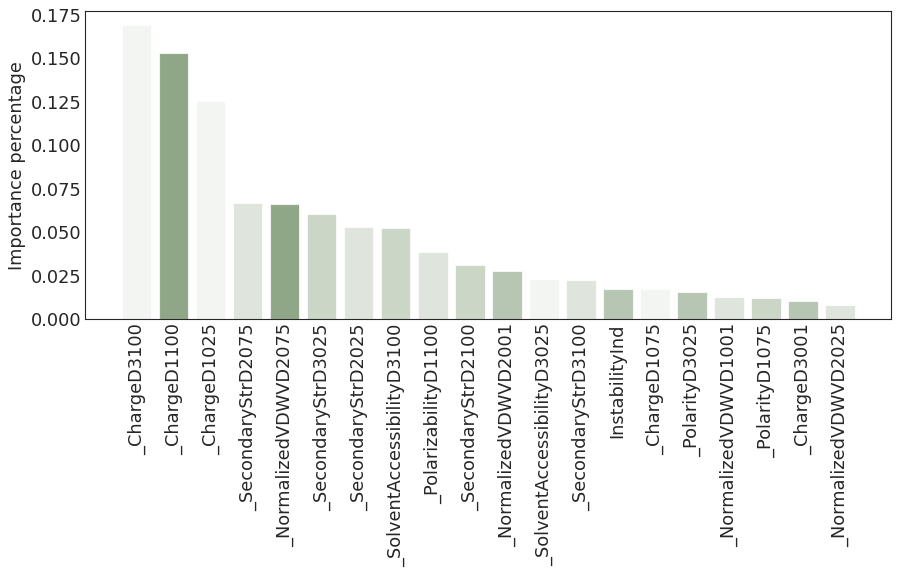

In [ ]:
fig, ax = plt.subplots(figsize=(13,5), facecolor='white', dpi= 80)
for key in list(not_null_sorted)[:20]:
    plt.bar(height=not_null_sorted[key][1], x=key, color = random.choice(sns.color_palette('light:#618255')), alpha = 0.7)
ax.set_ylabel('Importance percentage')
plt.xticks(rotation=90)
plt.show()

In [ ]:
sum = 0
names = list()
list_sum_not_null = list()
sum_not_null = dict()
for i, key in enumerate(not_null_sorted.keys()):
    sum += not_null_sorted[key][1]
    names.append(key)
    sum_not_null[i] = [sum]
    sum_not_null[i].append(names.copy())
    list_sum_not_null.append(sum)
df_LASSO = df_DESC[sum_not_null[16][1]].copy()
final_desc = sorted(sum_not_null[19][1])

In [ ]:
#Normalisation
scaler = StandardScaler()
df_LASSO = df_DESC[final_desc].copy()
df_LASSO = scaler.fit_transform(df_LASSO)

Text(0.3, 0.91, '0.98')

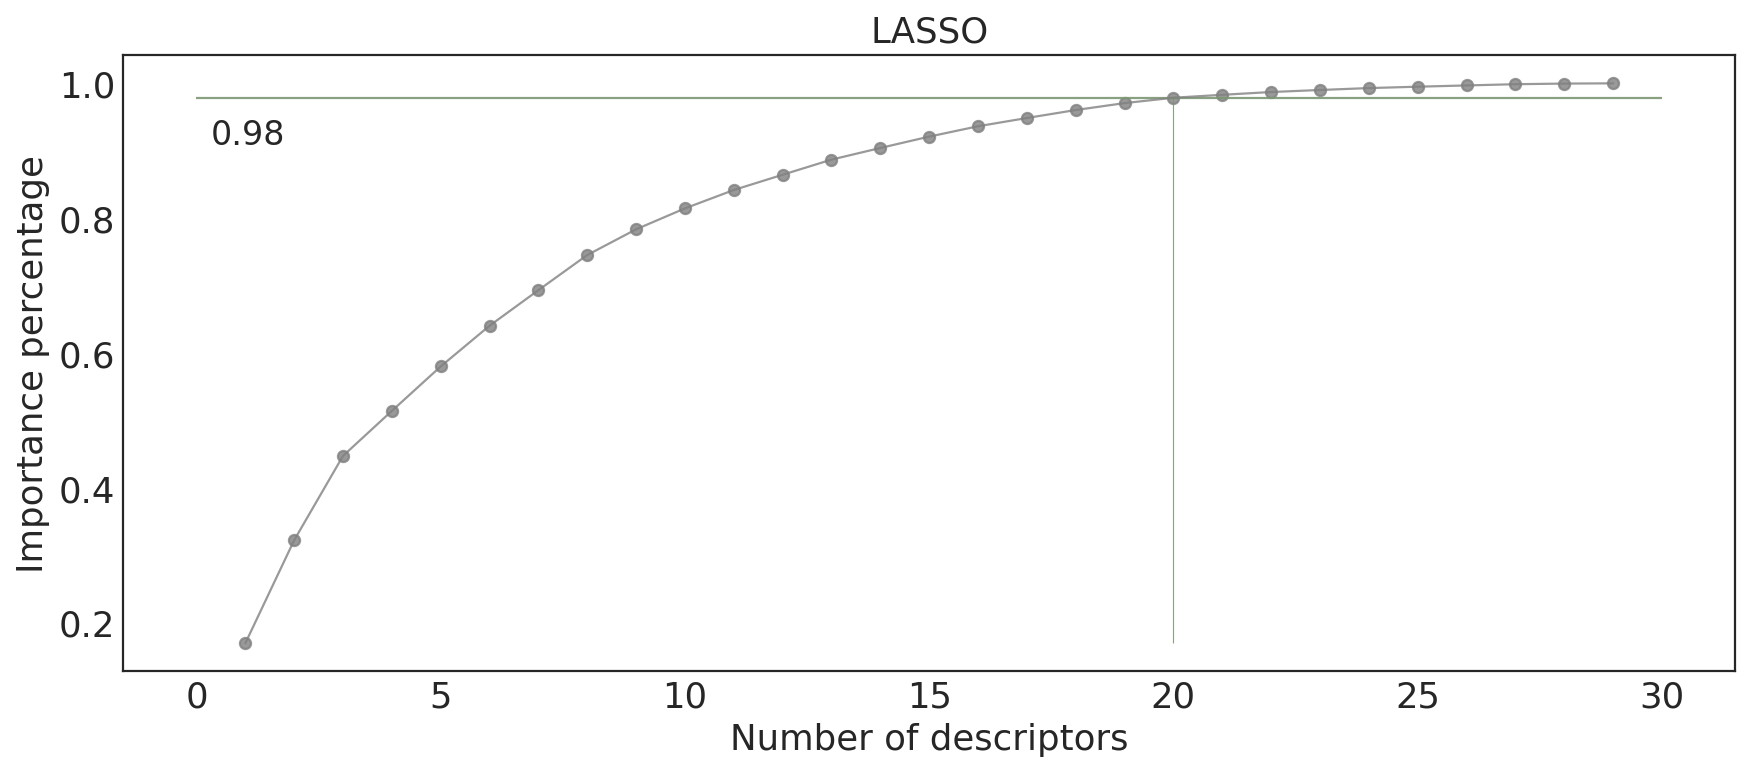

In [ ]:
fig, ax = plt.subplots(figsize=(13,5), facecolor='white', dpi= 160)
ax.vlines(x=20, ymin=list_sum_not_null[0], ymax=list_sum_not_null[19], color='#7c9772', alpha=0.9, linewidth=0.5)
ax.scatter(x=list(range(1,30)), y=list_sum_not_null, s=25, color='gray', alpha=0.8)
ax.hlines(y=list_sum_not_null[19], xmin=0, xmax=30, color='#7c9772', alpha=0.9, linewidth=1, linestyles='solid')
plt.plot(list(range(1,30)), list_sum_not_null, color='gray', lw=1, alpha=0.8)
ax.set_xlabel('Number of descriptors')
ax.set_ylabel('Importance percentage')
plt.title('LASSO')
ax.text(0.3, 0.91, 0.98, fontsize = 15)

In [193]:
df_FINAL = df_SAMPLE[['CPP', 'Sequence'] + final_desc].copy()
df_FINAL.to_csv(CPP_sample_path + 'df_TRAINING_SAMPLE.csv', index = False)